In [483]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [484]:
import os
import math
import random

In [485]:
directory = "../images/Section-4/school/"

In [486]:
num_of_images = 0

In [487]:
def load_images():
    global num_of_images
    num_of_images = 0
    images = os.listdir(directory)
    # images.sort()
    ret_images = []
    image_names = []
    for img in images:
        image_names.append(img)
        ret_images.append(cv.imread(directory + img, cv.IMREAD_UNCHANGED))
        num_of_images += 1

    print(num_of_images)
    return ret_images, image_names



In [488]:
def sift_features(images):
    gray_images = []
    for img in images:
        gray_images.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))

    # Initiate SIFT detector
    sift = cv.SIFT_create()

    # Find the keypoint and descriptor with SIFT
    keypoints = [None] * num_of_images
    descriptors = [None] * num_of_images
    i = 0
    for img in gray_images:
        keypoints[i], descriptors[i] = sift.detectAndCompute(img, None)
        i += 1

    # Draw keypoints
    image_keypoints = [None] * num_of_images
    i = 0
    for img in images:
        image_keypoints[i] = np.empty(img.shape, dtype=np.uint8)
        cv.drawKeypoints(img, keypoints[i], image_keypoints[i])
        i += 1

    return image_keypoints, keypoints, descriptors



In [489]:
def calculate_matching(images, keypoints, descriptors):
    out_images = []
    good_matches = []
    ratio = 0.75
    for i in range(0, len(images) - 1):
        bf = cv.BFMatcher()
        matches = bf.knnMatch(descriptors[i], descriptors[i+1], k=2)
        # Apply ratio test
        good = []
        for m, n in matches:
            if m.distance < ratio * n.distance:
                good.append([m])
        # Draw total matches
        img_matches = np.empty((max(images[i].shape[0], images[i+1].shape[0]), images[i].shape[1] + images[i+1].shape[1], 3),dtype=np.uint8)
        cv.drawMatchesKnn(images[i], keypoints[i], images[i+1], keypoints[i+1], outImg=img_matches, matches1to2=good, flags=2)

        out_images.append(img_matches)
        good_matches.append(good)

    return out_images, good_matches

In [490]:
def ransac(src_points, dst_points):
    ransac_reprojection_threshold, max_iters = 1.0, 1000
    H, mask = cv.findHomography(srcPoints=src_points, dstPoints=dst_points, method = cv.RANSAC, ransacReprojThreshold=ransac_reprojection_threshold, maxIters=max_iters)
    return H, mask

In [491]:
def prepare_data_and_run_ransac(keypoints, good, images):
    homographies = []
    inlier_images = []
    for i in range(0, num_of_images - 1):
        src = np.float32([keypoints[i][g[0].queryIdx].pt for g in good[i]])
        dst = np.float32([keypoints[i+1][g[0].trainIdx].pt for g in good[i]])

        H, mask = ransac(src, dst)

        homographies.append(H)

        # Draw inliers
        img_inliers = np.empty((max(images[i].shape[0], images[i+1].shape[0]), images[i].shape[1] + images[i+1].shape[1], 3),dtype=np.uint8)
        good_temp = np.array(good[i])
        inliers = good_temp[np.where(np.squeeze(mask) == 1)[0]]
        cv.drawMatchesKnn(images[i], keypoints[i], images[i+1], keypoints[i+1], outImg=img_inliers, matches1to2=inliers, flags=2)
        inlier_images.append(img_inliers)

    return homographies, inlier_images


In [492]:
def panorama_composition(homographies, images):
    homo_arrays = [np.identity(3)]
    panorama_current = images[0]
    for i in range(len(images) - 1):
        #Add current H to list
        homo_arrays.insert(0, homographies[i])
        # Stitch images
        panorama_height = np.maximum(panorama_current.shape[0], images[i+1].shape[0])
        panorama_width = panorama_current.shape[1] + images[i+1].shape[1]
        panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.uint8)
        panorama[0:panorama_current.shape[0], 0:panorama_current.shape[1]] = panorama_current
        warped_img = cv.warpPerspective(images[i+1], np.linalg.multi_dot(homo_arrays), (panorama_width, panorama_height), flags=cv.WARP_INVERSE_MAP)

        # Blending
        temp_panorama = np.round(0.5 * panorama + 0.5 * warped_img).astype(np.uint8)
        temp_panorama[warped_img == [0, 0, 0]] = panorama[warped_img == [0, 0, 0]]
        temp_panorama[panorama == [0, 0, 0]] = warped_img[panorama == [0, 0, 0]]
        panorama_current = temp_panorama.copy()

    #Trim black padding that ay appears on the end of the panorama
    trim_index_top = 0
    for t in range(panorama_current.shape[1]-1, 0, -1):
        if np.sum(panorama_current[0][t]) != 0:
            trim_index_top = t
            break
    trim_index_bottom = 0
    for b in range(panorama_current.shape[1]-1, 0, -1):
        if np.sum(panorama_current[0][b]) != 0:
            trim_index_bottom = b
            break

    if trim_index_top > trim_index_bottom:
        trim_index = trim_index_top
    else:
        trim_index = trim_index_bottom

    return panorama_current[:, 0:trim_index, :]

In [493]:
def plot_original(images, names):
    fig1 = plt.figure("Original Images")
    i = 1
    for img in images:
        plt.subplot(1, num_of_images, i)
        plt.axis("off")
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(names[i-1])
        i += 1

In [494]:

def plot_sift(images, names):
    fig2 = plt.figure("SIFT Feature Detection")
    i = 1
    for img in images:
        plt.subplot(1, num_of_images, i)
        plt.axis("off")
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(names[i - 1])
        i += 1

In [495]:

def plot_matches(images, names):
    size = math.floor(num_of_images / 2)
    size2 = math.ceil(num_of_images / 2)
    fig3 = plt.figure("Feature Matching")
    i = 1
    for img in images:
        plt.subplot(size, size2, i)
        plt.axis("off")
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(names[i - 1] + " - " + names[i])
        i += 1

In [496]:

def plot_validate_inliers(images, names):
    size = math.floor(num_of_images / 2)
    size2 = math.ceil(num_of_images / 2)
    fig5 = plt.figure("Outliers Removal")
    i = 1
    for img in images:
        plt.subplot(size, size2, i)
        plt.axis("off")
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(names[i - 1] + " - " + names[i])
        i += 1

In [497]:
def plot_panorama(image):
    fig6 = plt.figure("Image Stitching")
    plt.axis("off")
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title("Panorama")

Loading Images...
2


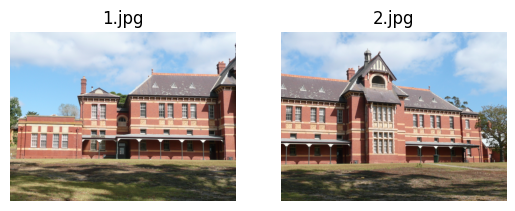

In [498]:

#Load and plot images
print("Loading Images...")
cv2_images, names = load_images()
plot_original(cv2_images, names)


Computing SIFT Features...


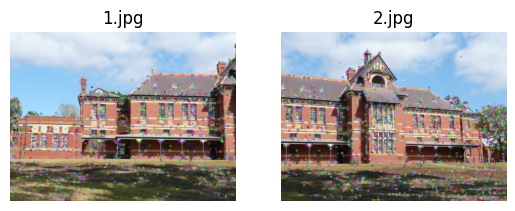

In [499]:

#Compute sift features and plot images
print("Computing SIFT Features...")
sift_images, keypoints, descriptors = sift_features(cv2_images)
plot_sift(sift_images, names)


Finding Good Matching...


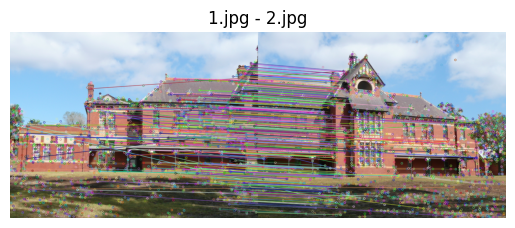

In [500]:

#Calculate matching and plot images
print("Finding Good Matching...")
matching_images, good = calculate_matching(sift_images, keypoints, descriptors)
plot_matches(matching_images, names)


Removing Outliers and Computing Homography Transformations (OpenCV's RANSAC)...


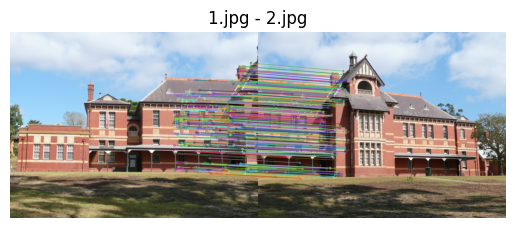

In [501]:

#Validate runsac
print("Removing Outliers and Computing Homography Transformations (OpenCV's RANSAC)...")
homographies_opencv, validate_inlier_images = prepare_data_and_run_ransac(keypoints, good, cv2_images)
plot_validate_inliers(validate_inlier_images, names)


In [502]:
homographies_opencv

[array([[ 1.34111590e+00, -4.96975183e-02, -6.71490248e+02],
        [ 1.68175658e-01,  1.26981871e+00, -9.01662514e+01],
        [ 4.25731056e-04, -1.70141959e-05,  1.00000000e+00]])]

Blending Images...


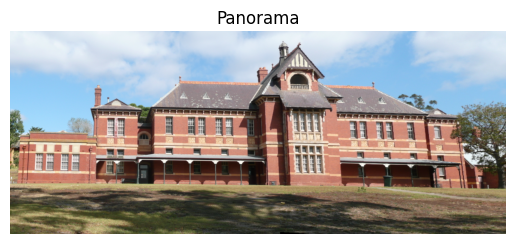

In [503]:

#Blending and Stiching and plot images
print("Blending Images...")
panorama_opencv = panorama_composition(homographies_opencv, cv2_images)
plot_panorama(panorama_opencv)

plt.show()